In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scarlet
import pickle

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP

import sep

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, hstack
from astropy.coordinates import SkyCoord

#plt.rcParams['font.size'] = 15
#plt.rc('image', cmap='inferno', interpolation='none', origin='lower')

### Make one figure containing all useful information

In [2]:
kz.utils.set_env(project='HSC', name='LSBG', data_dir='/tigress/jiaxuanl/Data')

'/tigress/jiaxuanl/Data/HSC/LSBG'

In [3]:
lsbg_cat = Table.read('./Cutout/Candy/candy_cutout_cat.fits')

In [5]:
lsbg_cat[:5]

<Table length=5>
     ra        dec     a_image b_image ...  radius image_flag [5] psf_flag [5]
                                       ...  arcsec                            
  float64    float64   float64 float64 ... float64      bool          bool    
----------- ---------- ------- ------- ... ------- -------------- ------------
225.3020883  1.0550868  26.224  17.616 ...     1.5   True .. True True .. True
181.0873682 -1.5183761  53.428  42.355 ...     1.0   True .. True True .. True
190.2022409  0.4494237  62.347  32.252 ...     1.0   True .. True True .. True
333.6455774  1.6049543   15.95   5.242 ...     1.0   True .. True True .. True
139.8679525  3.7603522  23.143  15.864 ...     1.0   True .. True True .. True

In [6]:
lsbg = lsbg_cat[0]
channels = 'grizy'

cutout = [fits.open(f"{lsbg['prefix']}_{band}.fits") for band in channels]
psf_list = [fits.open(f"{lsbg['prefix']}_{band}_psf.fits") for band in channels]

In [8]:
# Reconstructure data
from kuaizi.utils import padding_PSF
from kuaizi.mock import Data

images = np.array([hdu[1].data for hdu in cutout])
w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
filters = channels
weights = 1 / np.array([hdu[3].data for hdu in cutout])
psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
psfs = scarlet.ImagePSF(np.array(psf_pad))
data = Data(images=images, weights=weights, wcs=w, psfs=psfs, channels=channels)

### Run scarlet modeling

In [4]:
from kuaizi.fitting import fitting_wavelet_obs_tigress
import os

In [24]:
# scarlet_flag
# 0: not processed
# 1: no bug
# -1: problematic
lsbg_cat['scarlet_flag_0.5'] = np.zeros(len(lsbg_cat), dtype=int)

In [33]:
global_logger = kz.utils.set_logger(logger_name='candy_sample', file_name='candy_log', level='ERROR')

### Running scarlet wavelet modeling for `/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/Candy/candy_7`
  - Detect sources and make mask
    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    8 stars from Gaia are masked!
    Detected 214 objects
    5 stars from Gaia are masked!
    Detected 423 objects
    Detected 154 objects
  - Wavelet modeling with the following hyperparameters:
    min_grad = -0.30, starlet_thresh = 0.50 (contam_ratio = 0.04).
    Optimizaiton: Succeed for e_rel = 1e-04 with 84 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 86 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 1e-05 with 150 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 5e-05 with 152 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 1e-06 with 162 iterations! Try higher accuracy!
  - After 162 iterations, logL = 2783775.11
    Elapsed time for fitting: 588.53 s
  - Components [0] are 

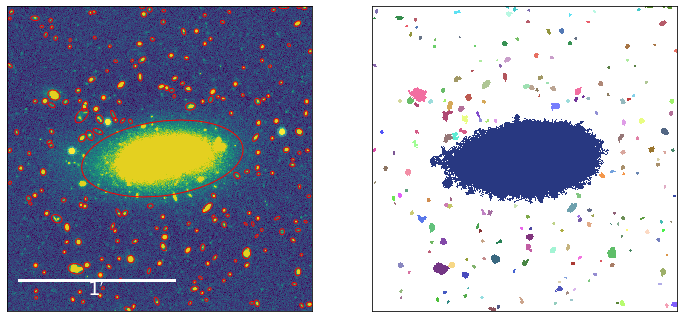

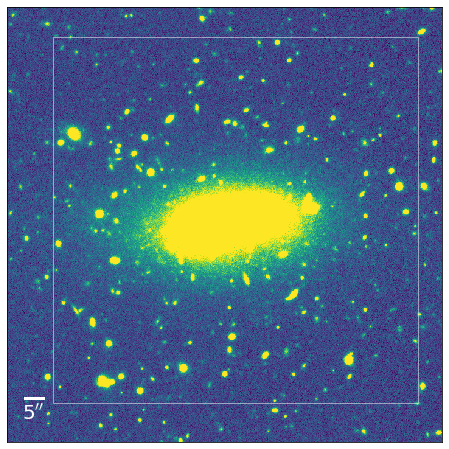

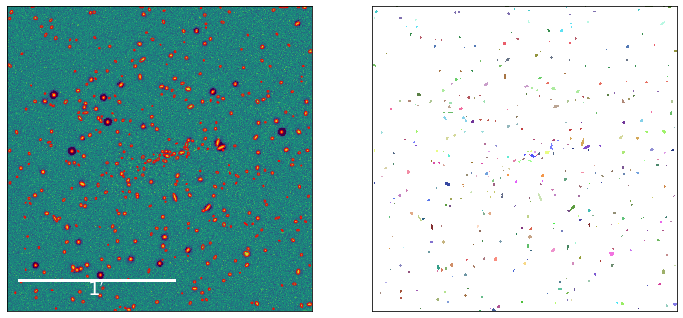

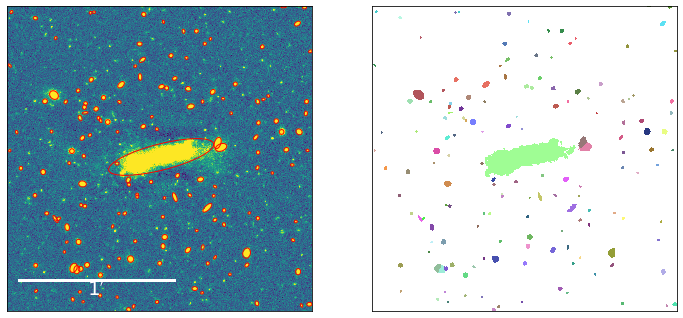

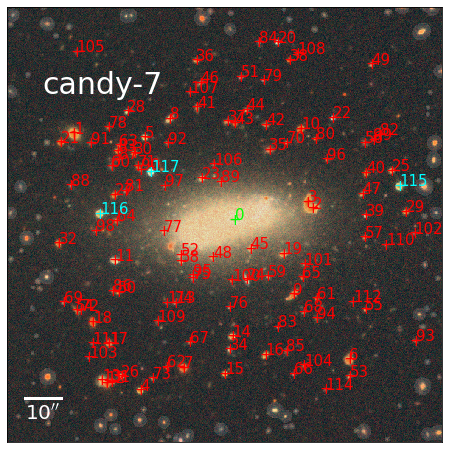

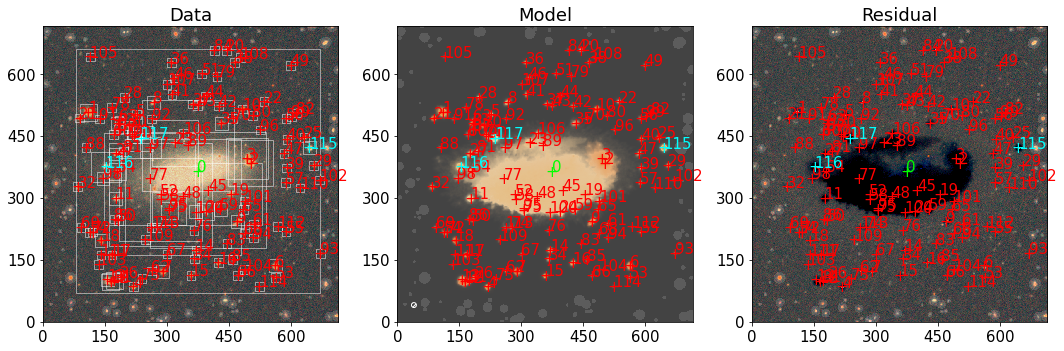

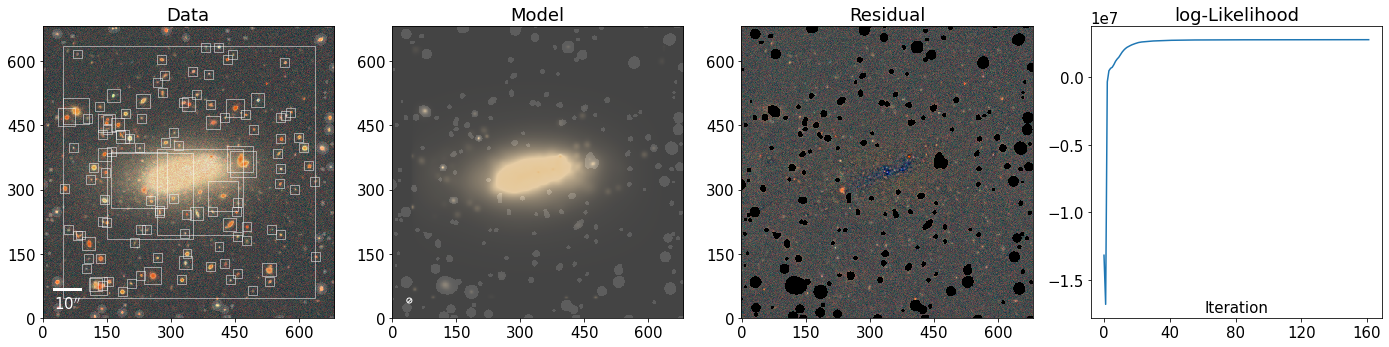

In [55]:
index = 7
blend = fitting_wavelet_obs_tigress(
    {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/tigress/jiaxuanl/Data'}, 
    lsbg_cat[index],
    name='Seq',
    channels='griz',
    starlet_thresh=0.5,
    prefix='candy',
    show_figure=True, 
    global_logger=None)

if blend: # if succeeded
    lsbg_cat[index]['scarlet_flag_0.5'] = 1
else:
    lsbg_cat[index]['scarlet_flag_0.5'] = -1

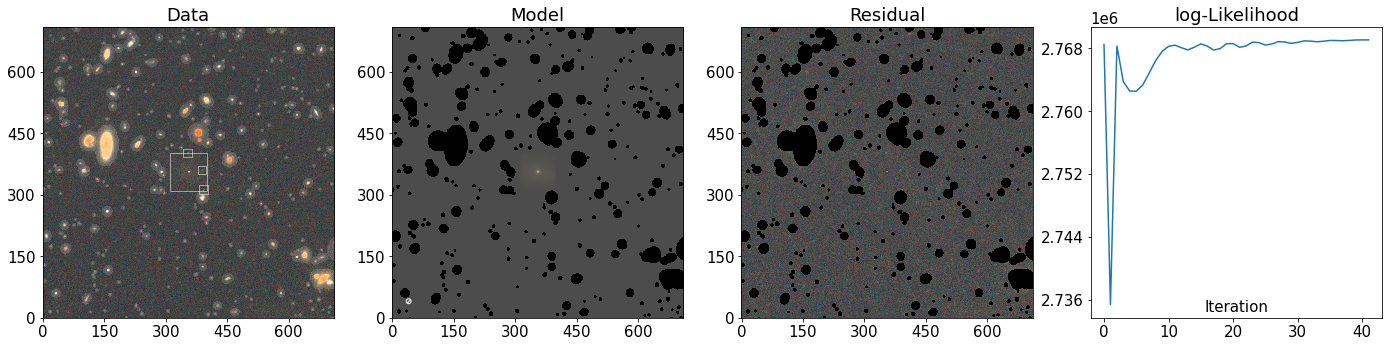

In [31]:
fig = kz.display.display_scarlet_results_tigress(
        blend,
        show_ind=[0],
        zoomin_size=120,
        minimum=-0.3,
        stretch=1,
        Q=1,
        channels='griz',
        show_loss=True,
        show_mask=True,
        show_mark=False,
        scale_bar=False)

In [6]:
import dill
with open('/tigress/jiaxuanl/Data/HSC/LSBG/Model/candy-27-trained-model-wavelet.df', 'rb') as f:
    blend, info, aggr_mask = dill.load(f)

## Multiprocessing

In [61]:
lsbg_cat['scarlet_flag_0.5'] = np.zeros(len(lsbg_cat), dtype=int)
global_logger = kz.utils.set_logger(logger_name='candy_sample', file_name='candy_log', level='ERROR')

In [62]:
from multiprocessing import Pool, Manager
from functools import partial

In [63]:
def multiprocess_fitting(index):
    #if not os.path.isfile(f'./Models/LSBG-{lsbg_cat[index]["Seq"]:04d}-trained-model-wavelet.df'): 
    blend = fitting_wavelet_obs_tigress(
        {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/tigress/jiaxuanl/Data'}, 
        lsbg_cat[index],
        name='Seq',
        channels='griz',
        starlet_thresh=0.5,
        prefix='candy',
        show_figure=False, 
        global_logger=global_logger)
    if blend: # if succeeded
        lsbg_cat[index]['scarlet_flag_0.5'] = 1
    else:
        lsbg_cat[index]['scarlet_flag_0.5'] = -1

print('Number of processor to use:')
n_jobs = 6
manager = Manager()
pool = Pool(n_jobs)

#measurement_cat = manager.dict()
iterable = np.arange(0, 21, 1) # np.random.randint(0, len(lsbg_cat), 50)

#func = partial(fitting_single_comp, s18a)
pool.map(multiprocess_fitting, iterable)
pool.close()
pool.join()

Number of processor to use:
### Running scarlet wavelet modeling for `/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/Candy/candy_2`
### Running scarlet wavelet modeling for `/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/Candy/candy_0`### Running scarlet wavelet modeling for `/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/Candy/candy_1`### Running scarlet wavelet modeling for `/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/Candy/candy_4`
### Running scarlet wavelet modeling for `/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/Candy/candy_3`
### Running scarlet wavelet modeling for `/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/Candy/candy_5`


  - Detect sources and make mask
    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
  - Detect sources and make mask  - Detect sources and make mask  - Detect sources and make mask  - Detect sources and make mask



    Query GAIA stars...    Query GAIA stars...    Query GAIA stars...    Query GAIA stars...



    Taking Gaia catalogs stored in `Tigress`    Taking Gaia catalo

## Generate html

In [64]:
!cp /tigress/jiaxuanl/Data/HSC/LSBG/Figure/candy-*-zoomin-*.png /tigress/jiaxuanl/public_html/candy/scarlet_zoomin

In [65]:
# webpage at `/tigress/jiaxuanl/public_html/candy/cutout_inspect.html`
# http://tigress-web.princeton.edu/~jiaxuanl/candy/cutout_inspect.html
for i in range(21):
#     print('<div class="row">')
#     print(f'      <figure> <img src="zoomin/candy_{i}_zoomin_wavelet.png"> <figcaption>Candy {i}</figcaption> </figure>')
#     print('</div>')
    
    print(f'<div class="row" id="candy{i}"> <figure> <img src="scarlet_zoomin/candy-{i}-zoomin-wavelet.png" style="width:70%"> <figcaption>Candy {i}</figcaption> </figure> </div>')

<div class="row" id="candy0"> <figure> <img src="scarlet_zoomin/candy-0-zoomin-wavelet.png" style="width:70%"> <figcaption>Candy 0</figcaption> </figure> </div>
<div class="row" id="candy1"> <figure> <img src="scarlet_zoomin/candy-1-zoomin-wavelet.png" style="width:70%"> <figcaption>Candy 1</figcaption> </figure> </div>
<div class="row" id="candy2"> <figure> <img src="scarlet_zoomin/candy-2-zoomin-wavelet.png" style="width:70%"> <figcaption>Candy 2</figcaption> </figure> </div>
<div class="row" id="candy3"> <figure> <img src="scarlet_zoomin/candy-3-zoomin-wavelet.png" style="width:70%"> <figcaption>Candy 3</figcaption> </figure> </div>
<div class="row" id="candy4"> <figure> <img src="scarlet_zoomin/candy-4-zoomin-wavelet.png" style="width:70%"> <figcaption>Candy 4</figcaption> </figure> </div>
<div class="row" id="candy5"> <figure> <img src="scarlet_zoomin/candy-5-zoomin-wavelet.png" style="width:70%"> <figcaption>Candy 5</figcaption> </figure> </div>
<div class="row" id="candy6"> <fig